In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
import os, sys
import re
import json
import glob
import datetime
from collections import Counter

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from wordcloud import WordCloud

In [4]:
# Add parent directory to path to import modules from src
rpath = os.path.abspath('..')
if rpath not in sys.path:
    sys.path.insert(0, rpath)

from src.loader import SlackDataLoader
from src.draw import Visualize
import src.utils as utils

## Insight Extraction

Below are some useful questions to answer. Feel free to explore to answer other interesting questions that may be of help to get insight about student's behaviour, need, and future performance 

In [70]:

paths = [
    '/home/biniyam/tenx-tasks/tenxdata/all-week8',
    '/home/biniyam/tenx-tasks/tenxdata/all-week9'
]
parsed_data = SlackDataLoader.slack_parser(paths)

# Find the user with the highest reply count
user_reply_counts = parsed_data.groupby('sender_name')['reply_count'].sum()
user_with_highest_replies = user_reply_counts.idxmax()
highest_reply_count = user_reply_counts.max()

print(f"The user with the highest number of reply counts is: {user_with_highest_replies} with {highest_reply_count} replies.")


The user with the highest number of reply counts is: Katie Dickerson with 19 replies.


Top and Bottom 10 by Reply counts

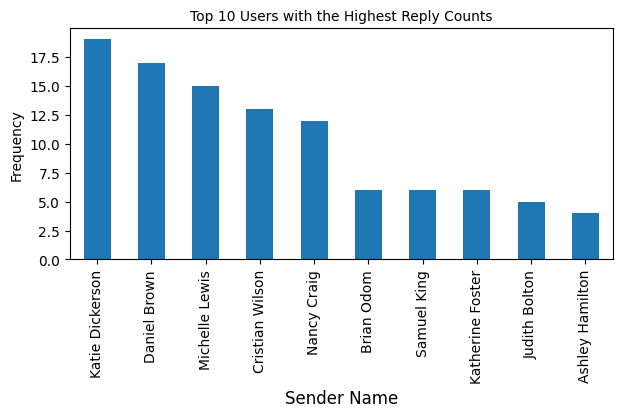

In [71]:
reply_counts = parsed_data.groupby('sender_name')['reply_count'].sum().sort_values(ascending=False)
reply_counts[:10].plot(kind='bar', figsize=(7, 3))
plt.title('Top 10 Users with the Highest Reply Counts', size=10)
plt.xlabel("Sender Name", size=12); plt.ylabel("Frequency", size=10);
plt.xticks(size=10); plt.yticks(size=10);
plt.show()


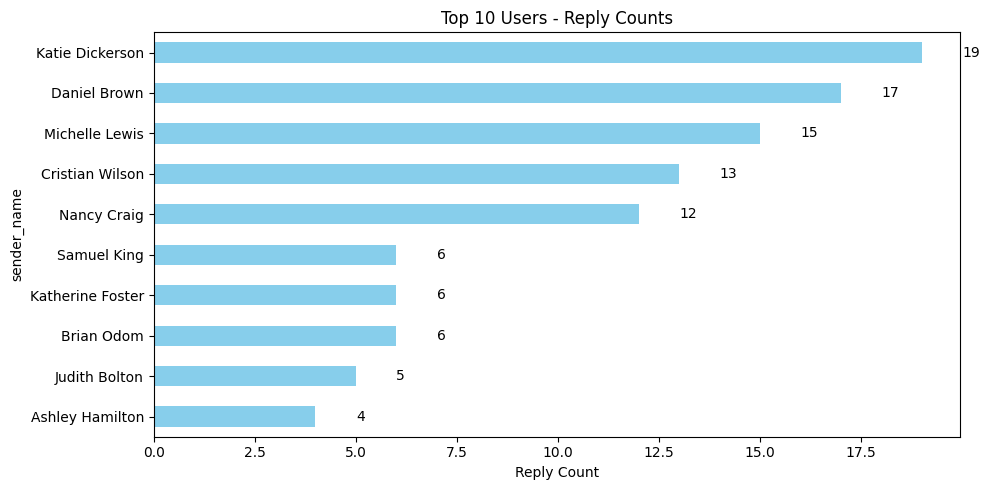

In [83]:
parsed_data_cleaned = parsed_data.dropna(subset=['reply_count'])

user_reply_counts = parsed_data.groupby('sender_name')['reply_count'].sum()
top_10_users_replies = user_reply_counts.nlargest(10)


# Plotting top 10 users with their reply counts
plt.figure(figsize=(10, 5))
fig.suptitle('Top 10 Users - Reply Counts', fontsize=15)

top_10_users_replies_sorted = top_10_users_replies.sort_values()
top_10_users_replies_sorted.plot(kind='barh', color='skyblue')
plt.xlabel('Reply Count')
plt.title('Top 10 Users - Reply Counts')



# Displaying top 10 users' reply counts
for i, v in enumerate(top_10_users_replies_sorted):
    plt.text(v + 1, i, str(v), color='black', va='center')

plt.tight_layout()
plt.show()


In [95]:
# # Plotting bottom 10 users with their reply counts

bottom_10_users_replies = user_reply_counts.nsmallest(10)
bottom_10_users_replies_sorted = bottom_10_users_replies.sort_values()

bottom_10_users_df = bottom_10_users_replies_sorted.reset_index()

# bottom_10_users_df.columns = ['sender_name', 'reply_count']
# bottom_10_users_df['replies'] = bottom_10_users_df['reply_count']


#PLOTTING THESE WAS A BAD IDEA

# bottom_10_users_replies_sorted.plot(kind='barh', ax=axs[1], color='salmon')
# axs[1].set_xlabel('Reply Count')
# axs[1].set_title('Bottom 10 Users - Reply Counts')

# # Displaying bottom 10 users' reply counts
# for i, v in enumerate(bottom_10_users_replies_sorted):
#     axs[1].text(v + 1, i, str(v), color='black', va='center')

# plt.tight_layout()
# plt.show()

bottom_10_users_df.head(10)

,sender_name,reply_count
0,Allison Thompson,0
1,Amy Leon,0
2,April Lucas,0
3,Brady Rhodes,0
4,Brittany Garcia,0
5,Carlos Gross,0
6,Debra Lawrence,0
7,Garrett Bell,0
8,Gary Thomas,0
9,Jennifer Foley,0


In [90]:
top_10_replies = parsed_data.nlargest(10, 'reply_count')[['msg_content', 'reply_count']]
# top_10_replies = top_10_replies[::-1]

# plt.figure(figsize=(10, 15))
# plt.barh(top_10_replies['msg_content'], top_10_replies['reply_count'], color='skyblue')
# plt.xlabel('Reply Count', size=12)
# plt.ylabel('Message Content', size=12)
# plt.title('Top 10 Messages by Reply Count', size=14)
# plt.tight_layout()
# plt.show()

print("Top 10 messages by reply count:")
print("================================")
for idx, row in top_10_replies.iterrows():
    print(f"Reply Count: {row['reply_count']} - Message: {row['msg_content']}")
    print("--------------------------------")

Top 10 messages by reply count:
Reply Count: 18 - Message: How could I join the two tables? do they have a common attribute that can I use to merge them together?
--------------------------------
Reply Count: 11 - Message: Hey <@U03UJGP0C68> try this
pip install causalnex==0.11.0
--------------------------------
Reply Count: 8 - Message: can i get a recorded tutorial of today’s  back testing?
--------------------------------
Reply Count: 7 - Message: During reading I witness a term (Security) in most of the provided docs, can anyone explain it?
--------------------------------
Reply Count: 6 - Message: When is the second tutorial scheduled for today
--------------------------------
Reply Count: 6 - Message: when cloning a repo, what's the difference between using git@gitrepolink and gitrepolink when cloning repo?
--------------------------------
Reply Count: 6 - Message: what about career exercise?
--------------------------------
Reply Count: 5 - Message: on the delivery_request data 

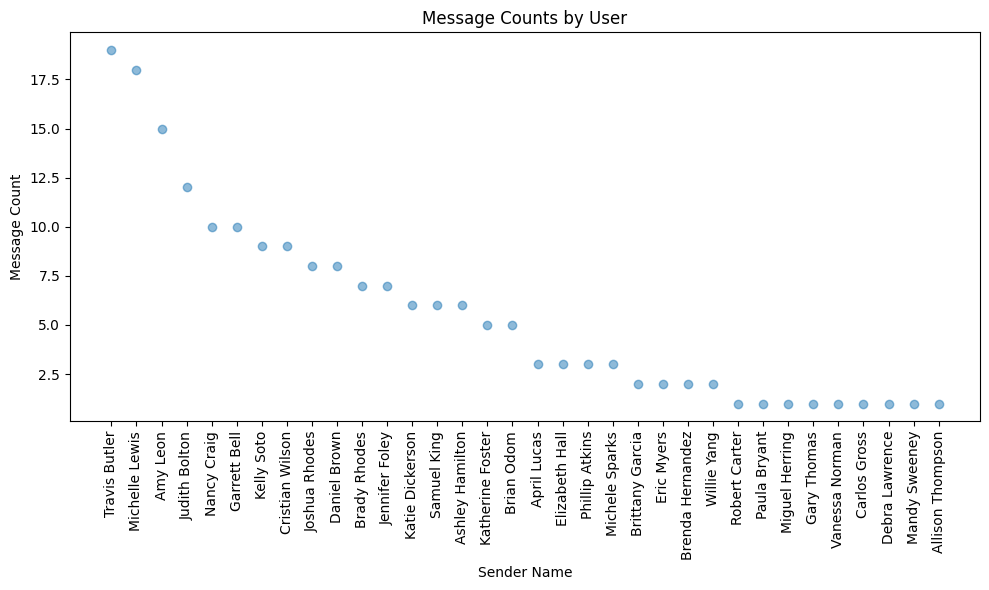

In [91]:
# User with the most messages
user_message_counts = parsed_data['sender_name'].value_counts()

user_message_counts_df = pd.DataFrame({'sender_name': user_message_counts.index, 'message_count': user_message_counts.values})

plt.figure(figsize=(10, 6))
plt.scatter(user_message_counts_df['sender_name'], user_message_counts_df['message_count'], alpha=0.5)
plt.xlabel('Sender Name')
plt.ylabel('Message Count')
plt.title('Message Counts by User')
plt.xticks(rotation=90)  # Rotating x-axis labels for better readability if needed
plt.tight_layout()
plt.show()

## Top 10 Users with most messages

<Figure size 1000x800 with 0 Axes>

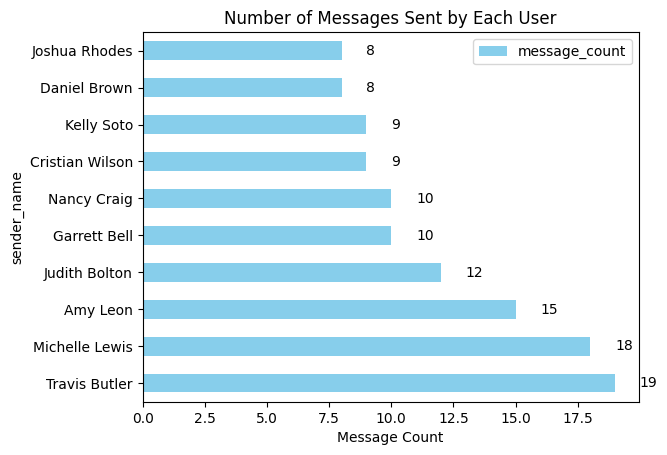

In [92]:
# Counting the number of messages sent by each user
user_message_counts = parsed_data.groupby('sender_name').size()

top_10_users = user_message_counts.nlargest(10)

user_message_counts_df = pd.DataFrame({'message_count': top_10_users.values}, index=top_10_users.index)

# Plotting the horizontal bar plot with annotations
plt.figure(figsize=(10, 8))
ax = user_message_counts_df.sort_values('message_count', ascending=False).plot(kind='barh', color='skyblue')
plt.xlabel('Message Count')
plt.title('Number of Messages Sent by Each User')

# Annotating counts near each bar
for i, (index, value) in enumerate(user_message_counts_df.iterrows()):
    ax.text(value['message_count'] + 1, i, str(value['message_count']), color='black', va='center')

plt.show()


## Bottom 10 with message count

In [98]:
#USERS WITH LESS messages than everyone

bottom_10_users_msg_df = pd.DataFrame({'sender_name': top_10_users.index, 'message_count': top_10_users.values})
bottom_10_users_msg_df.head(10)

# Rename columns
bottom_10_users_msg_df.columns = ['sender_name', 'message_count']
bottom_10_users_msg_df.head(10)



#PLOTTING THIS WAS A BAD IDEA TOO 

# user_message_counts_df = pd.DataFrame({'message_count': top_10_users.values}, index=top_10_users.index)\


# # Plotting the horizontal bar plot
# plt.figure(figsize=(10, 8))
# ax = user_message_counts_df.sort_values('message_count', ascending=False).plot(kind='barh', color='skyblue')
# plt.xlabel('Message Count')
# plt.title('Number of Messages Sent by Each User')

# for i, (index, value) in enumerate(user_message_counts_df.iterrows()):
#     ax.text(value['message_count'] + 1, i, str(value['message_count']), color='black', va='center')
# plt.show()

,sender_name,message_count
0,Willie Yang,2
1,Robert Carter,1
2,Paula Bryant,1
3,Miguel Herring,1
4,Gary Thomas,1
5,Vanessa Norman,1
6,Carlos Gross,1
7,Debra Lawrence,1
8,Mandy Sweeney,1
9,Allison Thompson,1


## Top and Bottom 10 by mention

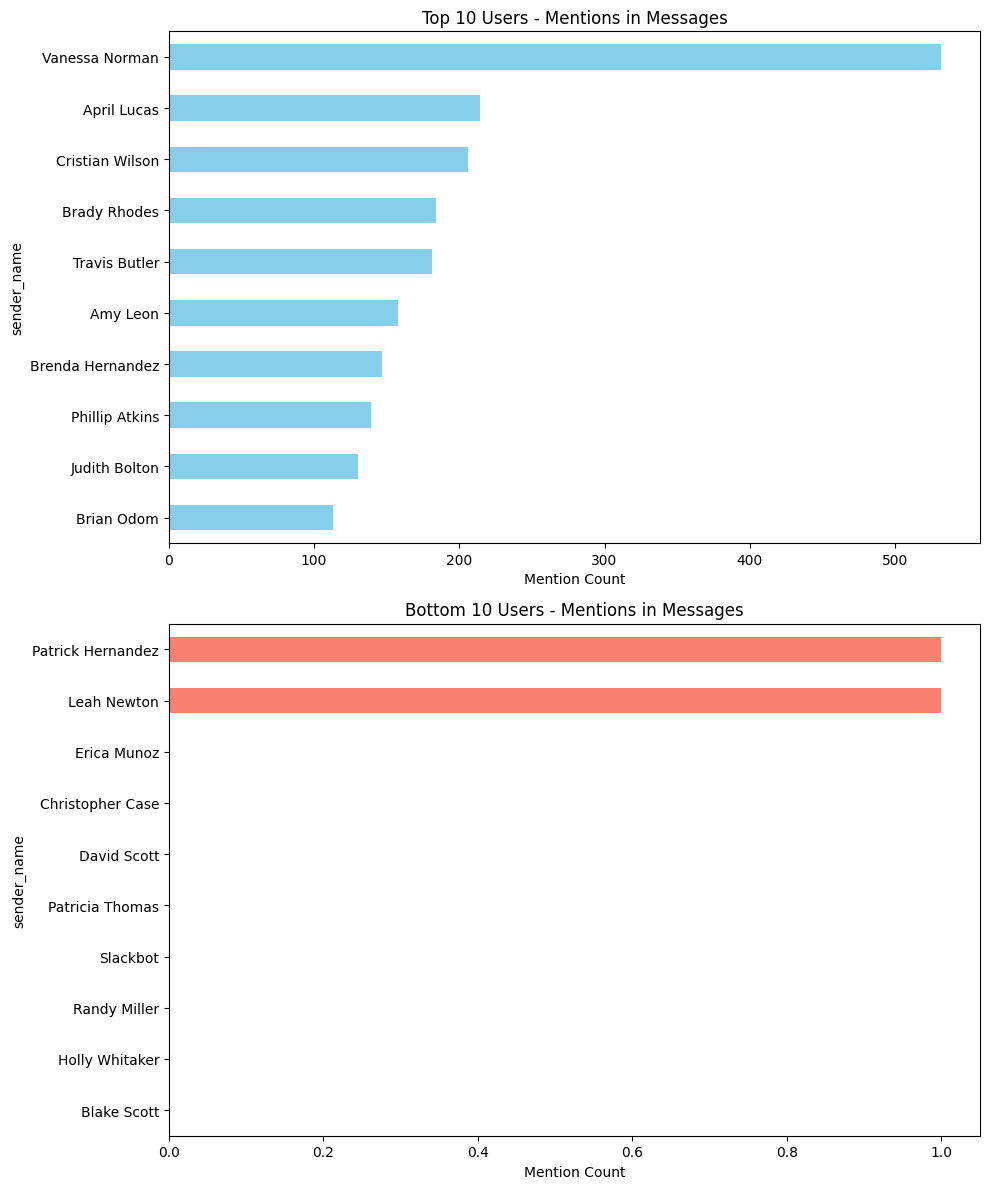

In [14]:
#Top 10 users with the highest number of mentions
mention_counts = parsed_data['msg_content'].str.count('@U\w+')

user_mention_counts = mention_counts.groupby(parsed_data['sender_name']).sum().sort_values(ascending=False)

top_10_users_mentions = user_mention_counts.nlargest(10)
bottom_10_users_mentions = user_mention_counts.nsmallest(10)

fig, axs = plt.subplots(2, 1, figsize=(10, 12))

# Top 10 users by mention count
top_10_users_mentions.sort_values().plot(kind='barh', ax=axs[0], color='skyblue')
axs[0].set_xlabel('Mention Count')
axs[0].set_title('Top 10 Users - Mentions in Messages')

# Bottom 10 users by mention count
bottom_10_users_mentions.sort_values().plot(kind='barh', ax=axs[1], color='salmon')
axs[1].set_xlabel('Mention Count')
axs[1].set_title('Bottom 10 Users - Mentions in Messages')

plt.tight_layout()
plt.show()

/tmp/ipykernel_6613/908396920.py:16: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


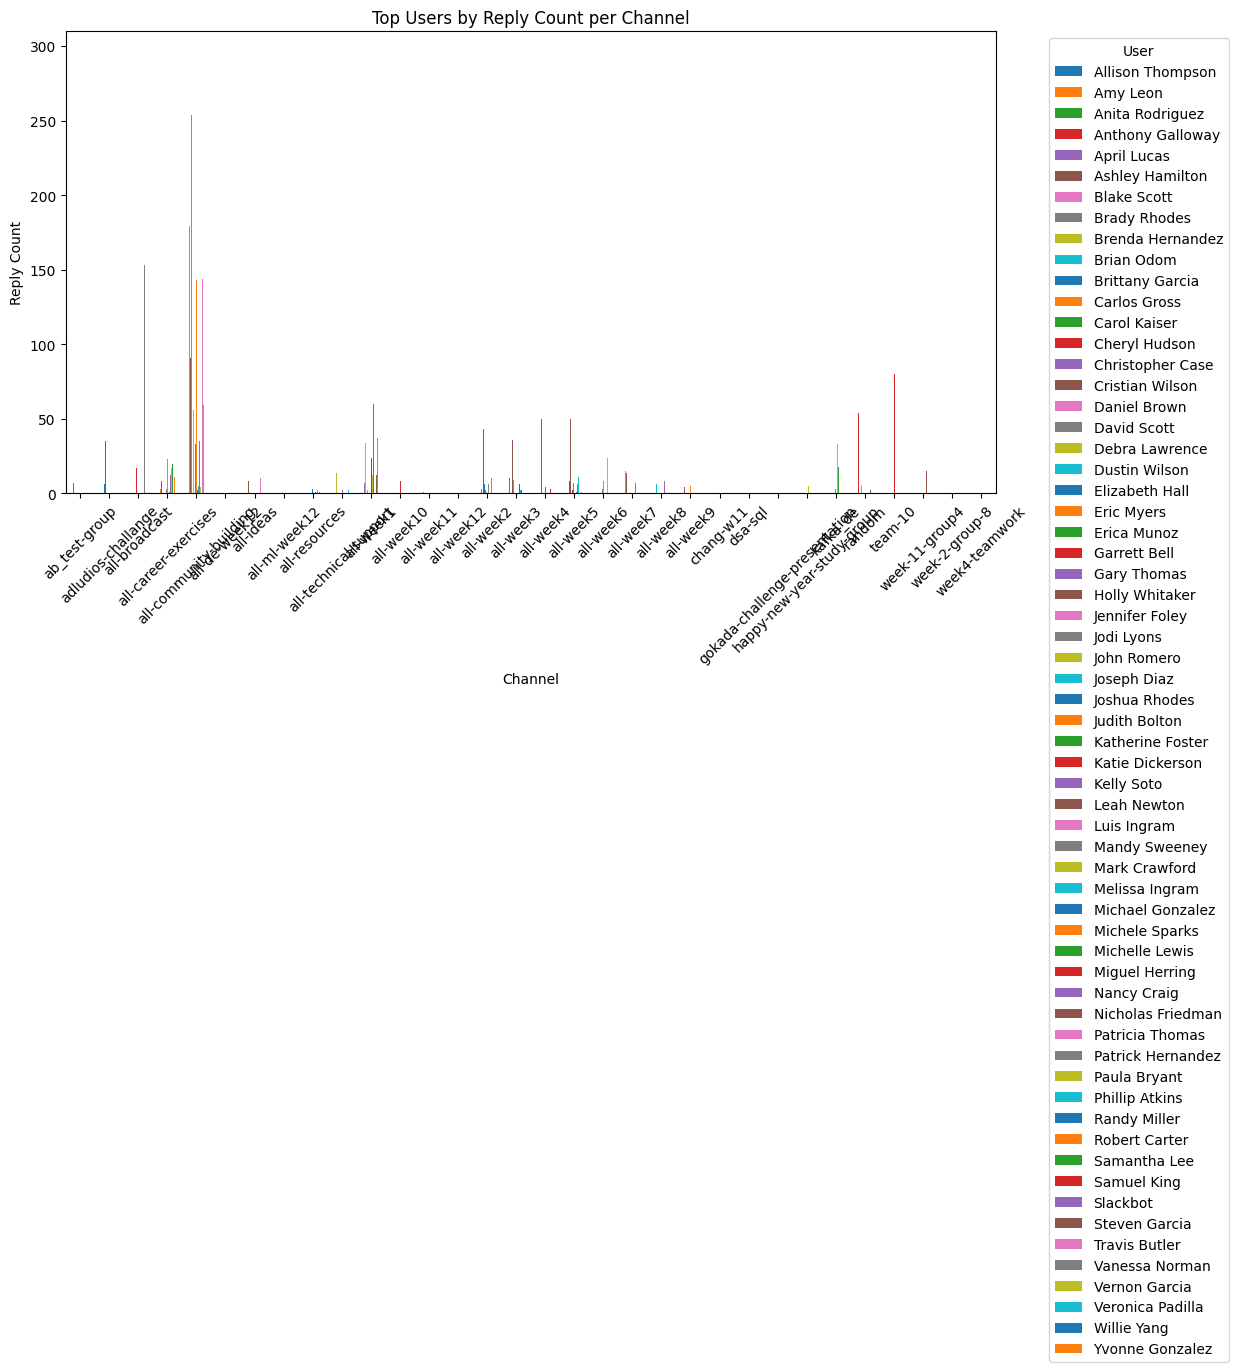

In [46]:
# Visualize reply counts per user per channel
parsed_data.groupby(['channel', 'sender_name'])['reply_count'].sum().unstack()

reply_counts = parsed_data.groupby(['channel', 'sender_name'])['reply_count'].sum().unstack()

# Displaying the top 10 users with the most reply counts for each channel
top_users_per_channel = reply_counts.apply(lambda x: x.sort_values(ascending=False).head(10))

# Creating a grouped bar chart
top_users_per_channel.plot(kind='bar', figsize=(12, 6))
plt.title('Top Users by Reply Count per Channel')
plt.xlabel('Channel')
plt.ylabel('Reply Count')
plt.legend(title='User', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


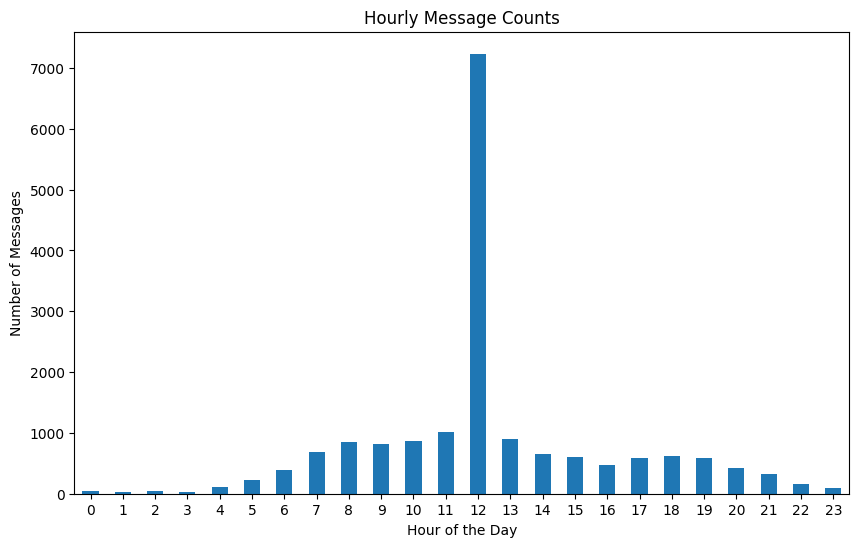

The hour with the most messages is 12:00 with 7233 messages.


In [16]:
# Convert 'msg_sent_time' column to datetime format
parsed_data['msg_sent_time'] = pd.to_datetime(parsed_data['msg_sent_time'], unit='s')

# Extract hour from message timestamps
parsed_data['hour_sent'] = parsed_data['msg_sent_time'].dt.hour

# Group messages by hour and count the number of messages in each hour
hourly_message_count = parsed_data.groupby('hour_sent').size()

# Find the hour with the maximum number of messages
hour_peak = hourly_message_count.idxmax()
max_messages = hourly_message_count.max()

# Visualize hourly message counts
hourly_message_count.plot(kind='bar', figsize=(10, 6))
plt.title('Hourly Message Counts')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Messages')
plt.xticks(rotation=0)
plt.show()

print(f"The hour with the most messages is {hour_peak}:00 with {max_messages} messages.")

In [63]:
#Parse reactions
path_channel = '/home/biniyam/tenx-tasks/tenxdata/'

#Parse reactions from all channels

channel = 'general'
parsed_reaction_data = SlackDataLoader.parse_slack_reaction(path_channel, channel)

# Find the most reacted message
most_reacted_message = parsed_reaction_data['msg'].value_counts().idxmax()

# Find the most reacted emoji
most_reacted_emoji = parsed_reaction_data['reaction'].value_counts().idxmax()

print(f"The most reacted message is: {most_reacted_message}")
print(f"The most reacted emoji is: {most_reacted_emoji}")

KeyError: 'msg'

In [24]:
#Message counts per channel dataframe
message_counts_per_channel = parsed_data['channel'].value_counts()
message_counts_df = message_counts_per_channel.reset_index()
message_counts_df.columns = ['channel', 'count']
message_counts_df.head(15)

,channel,count
0,all-community-building,7613
1,all-resources,1464
2,kafka_de,898
3,all-career-exercises,782
4,random,581
5,adludios-challange,574
6,all-week1,551
7,ab_test-group,546
8,all-broadcast,537
9,all-week7,456


In [ ]:
#Failed attempt at creating a correlation matrix

# msg_counts_df = pd.DataFrame({'channel': message_counts_per_channel.index, 'message_count': message_counts_per_channel.values})
# pivot_df = message_counts_df.pivot_table(index='channel', columns='channel', values='count', fill_value=0)




# plt.figure(figsize=(10, 6))
# c = pivot_df.corr()
# sns.heatmap(c, annot=False)
# plt.title('Correlation Matrix of Channels and their Message Counts')
# plt.show()


In [55]:
reply_counts_per_channel = parsed_data.groupby('channel')['reply_count'].sum().sort_values(ascending=False)
reply_counts_per_channel_df = reply_counts_per_channel.reset_index()
reply_counts_per_channel_df.columns = ['channel', 'reply_count']
reply_counts_per_channel_df.head(15)

,channel,reply_count
0,all-community-building,3062
1,all-career-exercises,460
2,all-week1,372
3,all-week7,264
4,all-week3,256
5,all-week4,180
6,all-broadcast,179
7,adludios-challange,178
8,all-week5,177
9,random,169


In [20]:
channel_activity['Total_Activity'] = channel_activity['Messages'] + channel_activity['Replies'] + channel_activity['Reactions']

plt.figure(figsize=(10, 6))
plt.scatter(channel_activity['Messages'], channel_activity['Total_Activity'], c=range(len(channel_activity)), cmap='viridis')
plt.xlabel('Number of Messages')
plt.ylabel('Sum of Replies and Reactions')
plt.title('Channel Activity')
plt.colorbar(label='Channels')
plt.show()

NameError: name 'channel_activity' is not defined

In [ ]:
# parsed_data = pd.DataFrame()
unique_channels = parsed_data['channel'].unique()
unique_channels_list = unique_channels.tolist()
print(unique_channels_list)

In [ ]:
# what kind of messages are replied faster than others?


In [ ]:
# Relationship between # of messages and # of reactions

In [ ]:
# Classify messages into different categories such as questions, answers, comments, etc.

In [ ]:
# Which users got the most reactions?

In [ ]:
# Model topics mentioned in the channel

In [ ]:
# What are the topics that got the most reactions?

### Harder questions to look into

In [ ]:
# Based on messages, reactions, references shared, and other relevant data such as classification of questions into techical question, comment, answer, aorder stu the python, statistics, and sql skill level of a user?